# Santander Value Prediction Challenge

In this competition, Santander Group is asking Kagglers to help them identify the value of transactions for each potential customer. This is a first step that Santander needs to nail in order to personalize their services at scale.

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor



## 2.Import dataset

In [2]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

print("Training Set:")
n_train_data=len(train_df)
n_train_features=train_df.shape[1]

print("Number of Records: {}".format(n_train_data))
print("Number of Features:{}".format(n_train_features))

print ("\nTesting set:")
n_test_data  = len(test_df)
n_test_features = test_df.shape[1]
print ("Number of Records: {}".format(n_test_data))
print ("Number of Features: {}".format(n_test_features))

Training Set:
Number of Records: 4459
Number of Features:4993

Testing set:
Number of Records: 49342
Number of Features: 4992


As we see in the data set, the training set have 4993 features (columns) but only have 445559 records (rows). Test set has 49342 records which is much more than the training set.

## 3.Understand the data

In [3]:
train_df.head(10)

,ID,target,48df886f9,0deb4b6a8,34b15f335,a8cb14b00,2f0771a37,30347e683,d08d1fbe3,6ee66e115,...,3ecc09859,9281abeea,8675bec0b,3a13ed79a,f677d4d13,71b203550,137efaa80,fb36b89d9,7e293fbaf,9fc776466
0,000d6aaf2,38000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
1,000fbd867,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
2,0027d6b71,10000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
3,0028cbf45,2000000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
4,002a68644,14400000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
5,002dbeb22,2800000.0,0.0,0,0.0,0,0,0,0,0,...,12000.0,5600000.0,20000000.0,0,0,0,0,0,0,11000
6,003925ac6,164000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,40000,0,0,0
7,003eb0261,600000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,0
8,004b92275,979000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,4000000.0,0,0,0,0,0,0,0
9,0067b4fef,460000.0,0.0,0,0.0,0,0,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,0,400000


Here I list the top 10 rows of traning set, noticed that there are many zero values in the data and the columns' name are anonymized.

In [4]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,3147
1,float64,1845
2,object,1


Most columns in the data set are integer and float number but there is only one column which has object data. This column is the ID column which we is not useful for us.

### 3.1 Check null values

In [5]:
print("Total Train Features with NaN Values = " + str(train_df.columns[train_df.isnull().sum() != 0].size))
print("\nTotal Test Features with NaN Values = " + str(test_df.columns[test_df.isnull().sum() != 0].size))

Total Train Features with NaN Values = 0

Total Test Features with NaN Values = 0


There is no NaN values in both training and testing data.

### 3.2 Check columns with constant data


In [6]:
unique_df = train_df.nunique().reset_index()  ## check number of distinct observations in each column
unique_df.columns = ["col_name", "unique_count"]
constant_df = unique_df[unique_df["unique_count"]==1] ## if the number of distinct observation in each column is 1 then this column has constant value

In [7]:
constant_df.shape

(256, 2)

There are 256 columns have constant value so we can get ride of these columns

In [8]:
train_df.drop(constant_df.col_name.tolist(),axis=1,inplace=True) ## Drop 256 columns with constant values

In [9]:
train_df.shape

(4459, 4737)

### 3.3 Check and Remove Duplicate Columns

In [10]:
train_df=train_df.T.drop_duplicates().T

In [11]:
train_df.shape

(4459, 4732)

There are 6 duplicate columns and remove 5 of them

### 3.4 Split data into training and target data

In [12]:
X_train=train_df.drop(['ID','target'],axis=1)
y_train=np.log1p(train_df['target'].values.astype(int))

X_test = test_df.drop(constant_df.col_name.tolist() + ["ID"], axis=1)

## 4.Feature Selection


In this section I will use three methods to determine importance of features.

In [13]:
feat_labels=list(X_train)

Create feature lables from training set

### 4.1 Feature importance using Gradient Boosting Regressor

In [15]:
clf_gb = GradientBoostingRegressor(random_state = 42)
clf_gb.fit(X_train, y_train)
print(clf_gb)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)


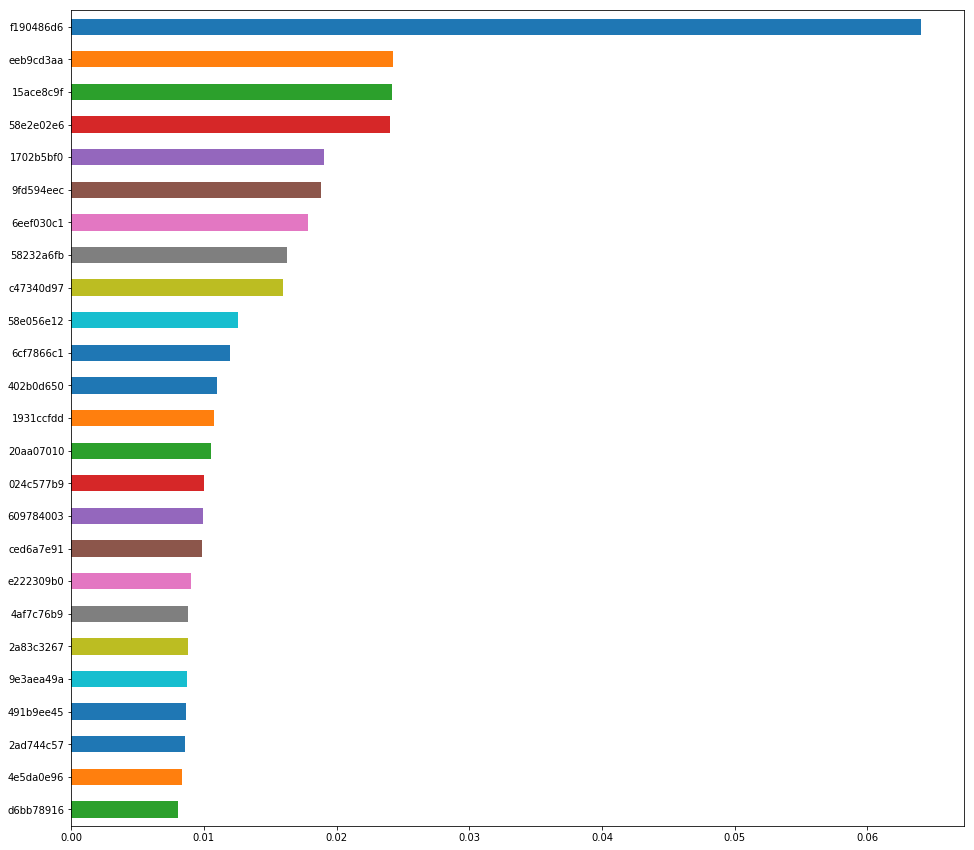

In [59]:
feat_importances = pd.Series(clf_gb.feature_importances_, index=feat_labels)
feat_importances = feat_importances.nlargest(25)
plt.figure(figsize=(16,15))
feat_importances.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

Here I plot the top 25 features gradient boosting regressor. Below list the name of top 10 features and there importance.

In [17]:
print(pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.064083
eeb9cd3aa    0.024274
15ace8c9f    0.024146
58e2e02e6    0.024057
1702b5bf0    0.019042
9fd594eec    0.018810
6eef030c1    0.017882
58232a6fb    0.016268
c47340d97    0.015974
58e056e12    0.012544
dtype: float64


In [60]:
pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(200).sum()

0.9061505147765243

In [ ]:
The top 200 features will cover more than 90% of the total importance.

### 4.2 Feature importance using Random Froest Regressor

In [19]:
clf_rf = RandomForestRegressor(random_state = 42)
clf_rf.fit(X_train, y_train)
print(clf_rf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)


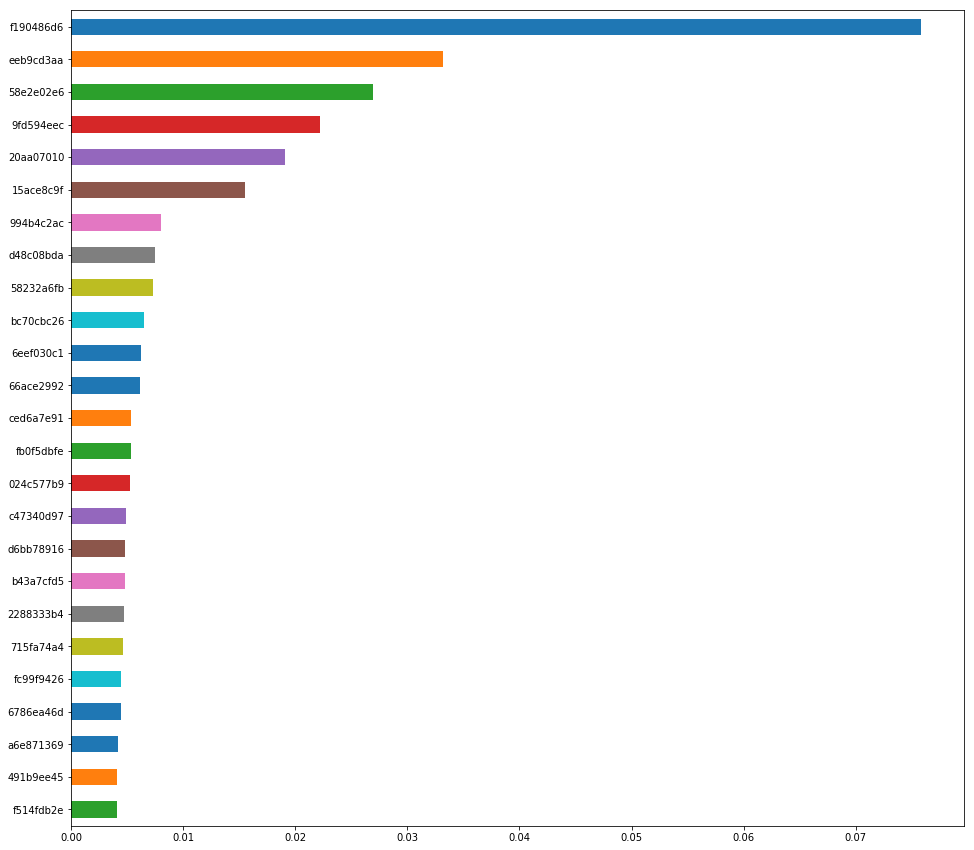

In [61]:
feat_importances_rf = pd.Series(clf_rf.feature_importances_, index=feat_labels)
feat_importances_rf = feat_importances_rf.nlargest(25)
plt.figure(figsize=(16,15))
feat_importances_rf.plot(kind='barh')
plt.gca().invert_yaxis()
plt.show()

In [21]:
print(pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10))

f190486d6    0.075868
eeb9cd3aa    0.033141
58e2e02e6    0.026906
9fd594eec    0.022162
20aa07010    0.019037
15ace8c9f    0.015485
994b4c2ac    0.008007
d48c08bda    0.007483
58232a6fb    0.007255
bc70cbc26    0.006506
dtype: float64


In [62]:
pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(200).sum()

0.595346606218152

Top 200 features only cover about 60% of total importance using random forest.

In [23]:
s1 = pd.Series(clf_gb.feature_importances_, index=X_train.columns).nlargest(10).index
s2 = pd.Series(clf_rf.feature_importances_, index=X_train.columns).nlargest(10).index

In [24]:
common_features = pd.Series(list(set(s1).intersection(set(s2)))).values

print(common_features)

['58232a6fb' '15ace8c9f' 'f190486d6' '9fd594eec' 'eeb9cd3aa' '58e2e02e6']


Compare two methods, for top 10 features there are 6 features in common (list above).

In [63]:
pd.Series(clf_gb.feature_importances_, index=X_train.columns)[common_features].sum()

0.17163853009401053

In [64]:
pd.Series(clf_rf.feature_importances_, index=X_train.columns)[common_features].sum()

0.18081625448951466

### 4.3 PCA transformation

In [69]:
from sklearn.decomposition import PCA
model_PCA=PCA(n_components=3)
model_PCA.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [70]:
transformed=model_PCA.transform(X_train)

In [71]:
print(transformed)

[[-15245763.04660639   -550039.23783836   -364987.53384122]
 [-21474297.49408241   -701365.2851572    -399840.03244196]
 [-29071160.16827439   -749162.21511689   -472211.63646212]
 ...
 [ 31705217.28804683   -896594.2128658    -563030.15914234]
 [-27472954.86134271   -747722.00161666   -472177.16979471]
 [  -386910.84158758   -935051.70017709   -556121.0611829 ]]


## 5.Modeling

First I will build a NN according to 6 main features mentioned in the previous section.

In [27]:
common_features=np.append(common_features,'target')

In [28]:
common_features

array(['58232a6fb', '15ace8c9f', 'f190486d6', '9fd594eec', 'eeb9cd3aa',
       '58e2e02e6', 'target'], dtype=object)

In [29]:
train_df1=train_df[common_features]


In [30]:
X_train1=train_df1.drop(['target'],axis=1)
y_train1=np.log1p(train_df1['target'].values.astype(int))



In [45]:
y_train1

array([17.45309674, 13.3046866 , 16.11809575, ..., 14.84513033,
       16.11809575, 16.81124288])

In [31]:
from sklearn.model_selection import train_test_split
X_train_1, X_test_1,y_train_1,y_test_1=train_test_split(X_train1,y_train1,test_size=0.4,random_state=0)

In [32]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train_1=sc.fit_transform(X_train_1)
X_test_1=sc.transform(X_test_1)

In [36]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [56]:
def baseline_model():
    model=Sequential()
    model.add(Dense(units=6,kernel_initializer='normal',activation='relu',input_dim=6))
    model.add(Dense(units=3,kernel_initializer='normal',activation='relu'))
    model.add(Dense(units=1,kernel_initializer='normal'))
    model.compile(optimizer='adam',loss='mean_squared_error')
    return model
    
    
   # model.fit(X_train_1,y_train_1,batch_size=10,epochs=100)

In [57]:
seed=7
np.random.seed(seed)
estimator=KerasRegressor(build_fn=baseline_model,epochs=100,batch_size=5,verbose=0)


In [58]:
kfold=KFold(n_splits=10,random_state=seed)
results=cross_val_score(estimator,X_train1,y_train1,cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -3.07 (0.17) MSE


In [43]:

np.random.seed(seed)
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=baseline_model, epochs=50, batch_size=5, verbose=0)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(pipeline, X_train1,y_train1, cv=kfold)
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Standardized: -2.95 (0.32) MSE


In [52]:
model=Sequential()
model.add(Dense(units=6,kernel_initializer='normal',activation='relu',input_dim=6))
model.add(Dense(units=3,kernel_initializer='normal',activation='relu'))
model.add(Dense(units=1,kernel_initializer='normal'))
model.compile(optimizer='adam',loss='mean_squared_error')
prediction=model.predict(X_train1)

In [53]:
prediction

array([[-14278.159 ],
       [     0.    ],
       [     0.    ],
       ...,
       [     0.    ],
       [ -1537.3229],
       [ -8473.393 ]], dtype=float32)

In [54]:
y_train1

array([17.45309674, 13.3046866 , 16.11809575, ..., 14.84513033,
       16.11809575, 16.81124288])

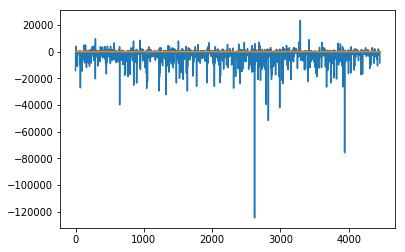

In [55]:
plt.plot(prediction)
plt.plot(y_train1)
plt.show()

Compare between prediction (blue) and actual data (orange)